# Objectives
The first objective is to predict 3 months of sales for 50 different items at 10 different stores.

The second objective is to answer each of the following questions:
- What's the best way to deal with seasonality? 
- Should stores be modeled separately, or can you pool them together? 
- Does deep learning work better than ARIMA? 
- Can either beat xgboost?

Technically, the objective is to predict the sales from 2018-01-01 to 2018-03-31 for stores 1 to 10 and items 1 to 50 in the test set where the train set is given.

# Data Acquisition

The objective is to get the train and test data sets and extract basic information before starting the data exploratory phase.

## Data Source

The data come from Kaggle and are downloaded [here](https://www.kaggle.com/c/demand-forecasting-kernels-only/data).


## Dataset Basic Information

We need to know how much data do we have in our data sets to help us determining a list of algorithms that will suit better to achieve the objectives.

- Number of rows
- Number of columns
- Percentage: number of rows of a data set / total number of rows of test + train sets * 100


In [1]:
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
import statsmodels.api as sm

from dateutil.relativedelta import relativedelta
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from scipy.stats import normaltest
from random import randint

from Utils import *

In [2]:
train = pandas.read_csv("Dataset/train.csv")
train_number_of_rows = len(train.index)
train_number_of_cols = len(train.columns)
print("Train set - Number of rows:", train_number_of_rows)
print("Train set - Number of columns:", train_number_of_cols)

test = pandas.read_csv("Dataset/test.csv")
test_number_of_rows = len(test.index)
test_number_of_cols = len(test.columns)
print("\nTest set - Number of rows:", test_number_of_rows)
print("Test set - Number of columns:", test_number_of_cols)

percentage_test = round(test_number_of_rows / (test_number_of_rows + train_number_of_rows) * 100, 2)
print("The test set contains", percentage_test, "% of the overall datasets.\n")

print(train.head())
print(train.tail())

Train set - Number of rows: 913000
Train set - Number of columns: 4

Test set - Number of rows: 45000
Test set - Number of columns: 4
The test set contains 4.7 % of the overall datasets.

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82


## Applicable Algorithms
We know that we have the sales for the 5 past years (2013-01-01 to 2017-12-31) from which we have to forecast the sales for the next 3 months (2018-01-01 to 2018-03-31). 

As the objectives specified, the following algorithms will be used in order to predict the next 3 months of sales:
- Seasonal and non-seasonal ARIMA (including or not exogenous variables)
- Neural Networks
- XGBoost (Extreme Gradient Boosting Trees)

# Data Exploration

The objective is to explore the training set in order to understand and visualize how the sales varies in function of the time for a random item of a random store. We take a random item because we only want to have an idea of how behave the sales and every time we will run this notebook, a new random item will be explored.

We have to check in the time series given in the train set:
- the seasonal behavior of the sales of the item in the store
- the seasonality and non seasonality trend of the sales over time
- the stationarity of the time series

Since this is items in stores demand, we know that it is about shopping. We are then interested on:
- __Sales by weekday__ because people may buy more on weekends (Friday, Saturday and Sunday), since most of people do not work on weekends.
- __Sales before, during and after holidays__ For example, people are generally in a rush to buy gifts just before Christmas (like December 23rd, December 24th). However, stores are mostly closed on Christmas.
- __Seasons (Winter, Spring, Summer and Fall)__ For example, if the store sells items used to sports practiced on Spring and Summer, people will start to buy on January or February until June or July in order to be ready for the Spring or/and Summer. Once the Summer will be at its end (August or September), it will be too late and then, the sales should decrease.
- __Anomalies__ because if the store got dammage or was robbed, the sales will be very low or even $0$. If there is a special event near the store, people may buy more items at that moment where normally the sales are not that good at that period of the year.

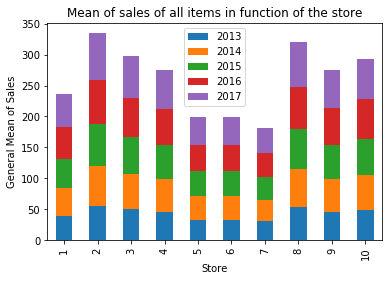

In [3]:
train_copy = train.copy()
train_copy.date = pandas.DatetimeIndex(train_copy.date)
train_copy.set_index('date', inplace=True)
store_year_mean = train_copy.groupby('store')['sales'].resample('YS').mean().reset_index()
store_year_mean = store_year_mean.set_index(['date', 'store']).stack().unstack('date').fillna(0)

dates = set(store_year_mean.stack().index.get_level_values(2))
dates = sorted([date.year for date in dates])

ax = store_year_mean.plot(kind='bar', 
                          stacked=True, 
                          title='Mean of sales of all items in function of the store')
ax.set(xlabel='Store', ylabel='General Mean of Sales')
ax.set_xticklabels(store_year_mean.index.get_level_values('store'))
ax.legend(dates);

## Rolling Mean & Standard Deviation
We start by exploring the sales of a random item in a random store as an example. The following steps have to be done:
1. Starts with a rolling mean in order to detect trends per month or per week.
2. Identify the seasonality from the time series plot and the dataset.
3. Check if the time series is stationnary or not.

We use the rolling mean to detect trends per month and also rolling standard deviation to overview the difference between the seasons for each year.

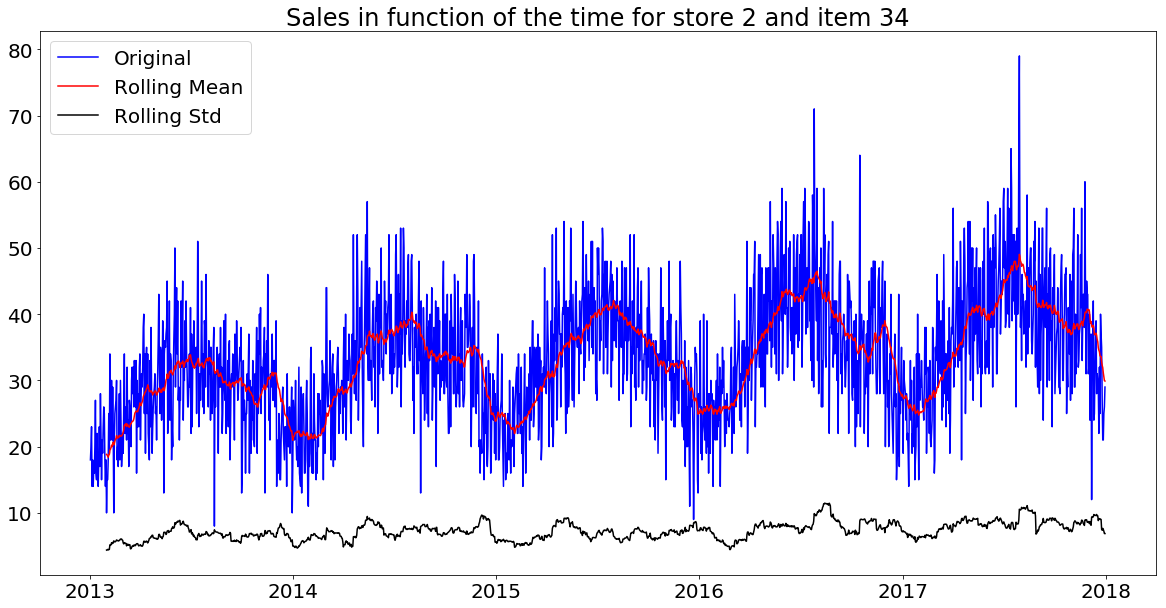

In [4]:
store_id = randint(1, 10)
item_id = randint(1, 50)

# Set the store index as the date with daily frequencies.
store = train.loc[(train.store == store_id) & (train.item == item_id), ['date', 'sales']]
store.date = pandas.DatetimeIndex(store.date)
store.set_index('date', inplace=True)
store = store.asfreq('D') 

# Determine the rolling means and the standard deviation per month.
rollmean = store.sales.rolling(30).mean()
rollstd = store.sales.rolling(30).std()

# Plot rolling mean and standard deviation.
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20})
plt.plot(store, color='blue',label='Original')
plt.plot(rollmean, color='red', label='Rolling Mean')
plt.plot(rollstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title("Sales in function of the time for store " + str(store_id) + " and item " + str(item_id))
plt.show(block=False)

We clearly see a pattern of increasing and decreasing trends described by the mean every year. The variance is not varying significantly. Thus, there is no need to apply a logarithm or square root transformation on the sales in order to stabilize the variance. Let's take a look at the seasonal decomposition plot.

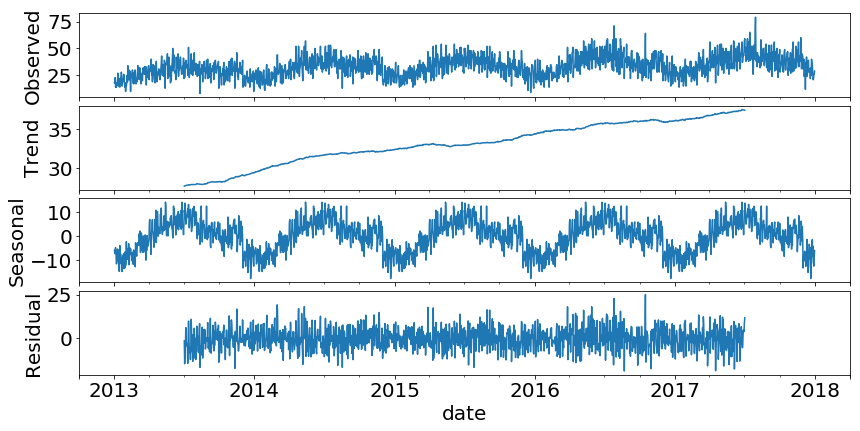

In [7]:
diagnostics = sm.tsa.seasonal_decompose(store, model='additive', freq=365)
diagnostics.plot()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
plt.show()

From the trend plot, we see that the sales trend increase slowly over years which shows the non stationarity of the time series. We also see the pattern on the seasonal plot where this pattern is repeated every year. 


## Weekdays Sales Visualization
We also want to visualize which week days have the best sales.

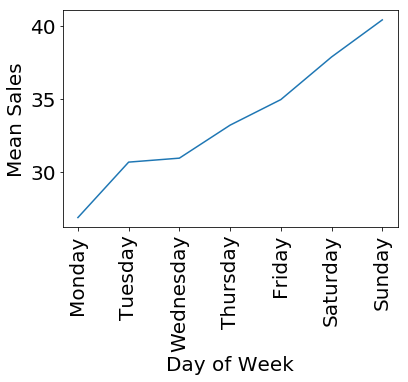

In [6]:
import calendar
store_mean_by_day = store.groupby(store.index.dayofweek).mean()
ax = store_mean_by_day.plot(legend=None)
ax.set(xlabel='Day of Week', ylabel='Mean Sales')
ax.xaxis.set_ticks(np.arange(len(list(calendar.day_name))))
ax.xaxis.set_ticklabels(list(calendar.day_name), rotation=90);

We see that the sales increase in general from Monday to Sunday. However, Saturday and Sunday are the week days with the best sales. This follows the fact that people are shopping on weekends because they are mostly working on business days. Furthermore, stores may be opened later on Friday which could explain why the sales increased considerably from Friday to Sunday.


## Sales Mean By Month
The objective is to visualize the sales mean by month in order to observe if there is a clear pattern and then deduce the stationarity of the time series.

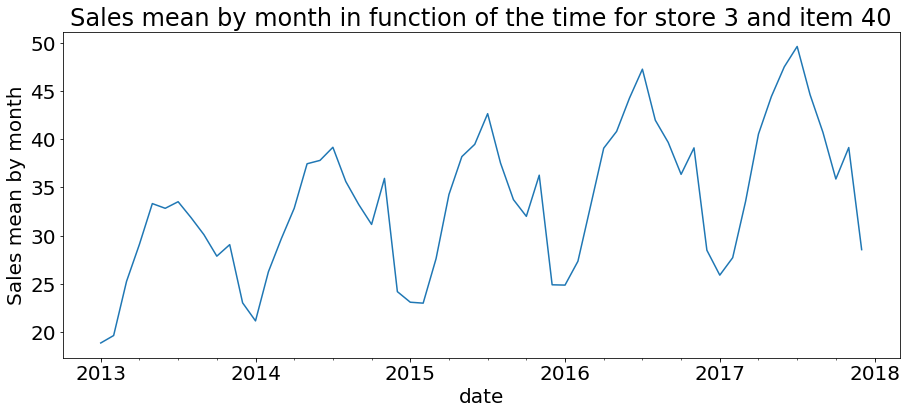

In [7]:
store_copy = store
store_by_month_mean = store_copy['sales'].resample("MS").mean()
ax = store_by_month_mean.plot(figsize=(15, 6), 
                              title="Sales mean by month in function of the time for store " + str(store_id) + " and item " + str(item_id))
ax.set_ylabel("Sales mean by month");

The following observations are identified:
- The trend increases slowly from year to year.
- The trend is clearly varying from month to month. 
- The trend seems to follow a similar pattern year after year. 

The time series has a seasonality pattern. In general, we have the following observations:
- From January to June, the sales are increasing. 
- It may occur that from March to April, the sales decreases a little.
- From June to September, the sales are decreasing.
- From September to October, the sales are increasing.
- From October to December, the sales are decreasing.
- From December to January, the sales are increasing. (It may occur that the sales continue to decrease.)

These observations suggest a seasonality at least per month. Hence, 12 seasons per year.

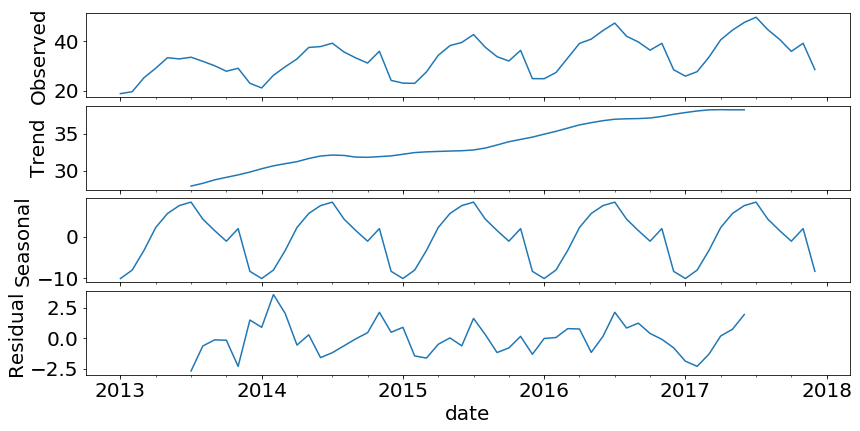

In [8]:
diagnostics = sm.tsa.seasonal_decompose(store_by_month_mean, model='additive')
diagnostics.plot()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
plt.show()

The trend is not constant implying that the time series is not stationary. We see that the pattern is clear for the seasonal time series which is repeated every year.


## Stationarity (Augmented Dickey-Fuller Test)
We want to stationarize the time series in order to obtain statistics such as the mean, variance and correlation with other variables as descriptors of how the future sales will behave.

One way to check the stationarity of the time series in function of the store and the item is to perform the Augmented Dickey-Fuller test. Since we want to test with drift and deterministic time trend, we define the regression model by 
$$\Delta X_t = c_0 + c_1t + (\phi_1 - 1) X_{t-1} + \epsilon_t$$
where $\Delta$ is the fist difference operator, $c_0$ is the drift and $c_1$ the coefficient for the time trend. Note that $X_t = \phi_1 X_{t-1} + \epsilon_t$ is the $AR(1)$ model that is defined in the $AR(p)$ Model section below.

We deduce from the linear model that there is a unit root only if $\phi_1 = 1$ because $X_t$ depends on passed observation $X_{t-1}$. Having $\phi_1 = 1$ gives $\Delta X_t = c_0 + c_1t + \epsilon_t$ which is the unit root.

We set the following hypotheses: 
- $H_0$: There is a unit root in $\Delta X_t$ implying that the time series is stationary.
- $H_1$: There is no unit root in $\Delta X_t$ implying that the time series is not stationary. 

Let $z$ be the test statistic and $z_{1-\alpha}$ be the critical value at a confidence level of $100(1-\alpha) \%$. Using the Dickey-Fuller critical value table with more than $500$ observations, drift and time trend, we have:
- For $\alpha = 0.99$, the critical value is $z_{0.01} = -3.96$
- For $\alpha = 0.95$, the critical value is $z_{0.05} = -3.41$
- For $\alpha = 0.90$, the critical value is $z_{0.10} = -3.12$

We choose that if $z < z_{0.01}$, we reject the null hypothesis $H_0$ and the time series is stationary. If $z \geq z_{0.01}$, we do not reject $H_0$ and the time series is not stationary.

In [9]:
TestStationarity(store_by_month_mean, 0.01)

Results of the Augmented Dickey-Fuller Test:
-----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     15.72
Date:                Sat, 19 Jan 2019   Prob (F-statistic):           9.89e-11
Time:                        12:11:27   Log-Likelihood:                -96.818
No. Observations:                  48   AIC:                             221.6
Df Residuals:                      34   BIC:                             247.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [10]:
TestStationarity(store.sales, 0.01)

Results of the Augmented Dickey-Fuller Test:
-----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     97.38
Date:                Sat, 19 Jan 2019   Prob (F-statistic):          6.94e-286
Time:                        12:11:27   Log-Likelihood:                -6028.6
No. Observations:                1805   AIC:                         1.210e+04
Df Residuals:                    1782   BIC:                         1.223e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

# (S)ARIMA Process: Box-Jenkins Methodology
As the objective of this analysis specified, we have to compare the accuracy and performance of the SARIMA model to a neural network model (deep learning). Therefore, we have to build the best (S)ARIMA model and predict the 3 months (2018-01-01 to 2018-03-31) with it. In order to fulfill our objective, we will use the Box-Jenkins methodology.



In order to use the SARIMA model, we have to select 7 parameters for which the accuracy of the prediction will be maximized. The following non-seasonal parameters are necessary:
- $AR(p)$:The auto-regressive part of the model noted $p$ represents the effect of past values.
- $I(d)$: The integrated part of the model noted $d$ represents the difference between the current value and the past values.
- $MA(q)$: The moving average part of the model noted $q$ represents the error of our model as a linear combination of the error values observed at previous time points in the past.

The 4 other parameters stand for the seasonality effects:
- $P, D, Q$ have respectively the same meaning as $p, d, q$.
- The periodicity of the time series noted $s$ which is expressed in terms of monthly periods. For example, $s = 12$ stands for monthly periods whereas $s = 4$ stands for quaterly periods.


## Theoric Introduction to ARIMA and SARIMA Models
We need to define variables before starting the analysis:
- Let $T = \{0, 1, \ldots, n\}$ be the set of times represented by the date in the dataset. Since the date starts on 2013-01-01, we define the time $t \in T$ in days such that $t = 0$ is 2013-01-01, $t = 1$ is 2013-01-02 until it reaches $t = n$ which is 2017-12-31. In the same idea, we define $\hat{T} = {n+1, n+2, \ldots, n+m}$ the set of future time given in the test set. Time $t = n+1$ is 2018-01-01, time $t=n+2$ is 2018-01-02 until it reaches $t = n+m$ which is 2018-03-31.
- Let $X_0, X_1, \ldots, X_n$ be the endogenous variables represented by the sales at time $t \in T$ given in the train dataset.
- We define the time series as $\{X_t, t \in T\}$.
- Let $L$ be the lag operator defined by $LX_t = X_{t-1}, L^2X_t = X_{t-2}, \ldots, L^kX_t = X_{t-k}$ where $t \geq k$. 
- Let $\Delta$ be the non-seasonal differencing operator such that $\Delta X_t = (1 - L)X_t = X_t - X_{t-1}$. For example, the second order differencing is $\Delta^2 X_t = (1 - L)^2X_t = (L^2 - 2L + 1)X_t = X_{t-2} - 2X_{t-1} + X_t$.
- Let $\Delta_s$ be the seasonal differencing operator such that $\Delta_s X_t = (1 - L^s)X_t = X_t - X_{t-s}$. For example, the second order differencing is $\Delta_s^2 X_t = (1 - L^s)^2 X_t = (L^{2s} - 2L^s + 1) X_t = X_{t-2s} - 2X_{t-s} + X_t$.
- Let $\hat{X}_t$ be our sales prediction of $X_t$ at time $t \in \hat{T}$.
- Let $\epsilon_t = X_t - \hat{X}_t$ the error between our sales prediction and the real value of the sales at time $t \in T$. We assume that $\epsilon_t \sim N(0, \sigma^2)$.


### Model $AR(p)$
The autoregressive model of order $p$ can be written as
$$X_t = (\alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \dots + \alpha_p X_{t-p}) + \epsilon_t$$ or equivalently $$\epsilon_t = \left(1 - \sum_{i = 1}^p \alpha_i L^i\right) X_t.$$

Let $\phi(L) = \left(1 - \sum_{i = 1}^p \alpha_i L^i\right)$ be the characteristic polynomial of the process where $\alpha = (\alpha_1, \alpha_2, \ldots, \alpha_p) \in \mathbb{R}^p$ is the vector of model coefficients. Therefore, we have $X_t \sim AR(p)$ where $\epsilon_t = \phi(L)X_t$.

It has been proven by Box and Jenkins that an $AR(p)$ process is stationary if and only if the roots $\lambda_1, \lambda_2, \ldots, \lambda_p \in \mathbb{C}$ of the characteristic polynomial ($\phi(L) = 0$) are outside the unit circle. This means that $|\lambda_1| > 1, |\lambda_2| > 1, \ldots, |\lambda_p| > 1$.

For example, a model $AR(1)$ is defined as 
$$\epsilon_t = X_t - \alpha_1 X_{t-1} = (1 - \alpha_1 L)X_t.$$ 
The characteristic polynomial is $\phi(L) = (1 - \alpha_1 L)$. We have $\phi(L) = 0$ if and only if we have the root $\lambda_1 = \frac{1}{\alpha_1}$ where $\alpha_1 \neq 0$. The process is stationary if and only if $|\alpha_1| < 1$. Hence, if $\epsilon_t = X_t - 0.81 X_{t-1} = (1 - 0.81 L)X_t.$, the process is stationary because $|0.81| < 1$.


### Model $MA(q)$
The moving average model of order $q$ can be written as
$$X_t = \epsilon_t + (\beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + \dots + \beta_q \epsilon_{t-q}) = \left(1 + \sum_{i = 1}^p \beta_i L^i\right) \epsilon_t.$$ 

Let $\theta(L) = \left(1 + \sum_{i = 1}^q \beta_i L^i\right)$ be the characteristic polynomial of the process where $\beta = (\beta_1, \beta_2, \ldots, \beta_p) \in \mathbb{R}^p$ is the vector of model coefficients. Therefore, we have $X_t \sim MA(q)$ where $X_t = \theta(L)\epsilon_t$. Note that a process $MA(q)$ is stationary for all $\beta_i \in \beta$.

For example, a model $MA(1)$ is defined as $$X_t = \epsilon_t + \beta_1 \epsilon_{t-1} = (1 + L\beta_1)\epsilon_t$$.


### Model $ARIMA(p, d, q)$
The ARIMA model is a non seasonal model using the past observations and the past errors as explanatory variables in order to describe future observations. In a first step, this model combines the $AR(p)$ and $MA(q)$ models which gives the $ARMA(p, q)$ model. This model can be written as
$$\phi(L)X_t = \theta(L)\epsilon_t.$$
The $ARMA(p, q)$ process is stationary if and only if the process $AR(p)$ is stationary.

Introducing the integration model $I(d)$ that differentiates with a lag $d \in \mathbb{N}$ the endogenous variables $X_{t-i}$ for $i = 0,1,\ldots,n$, this leads to the $ARIMA(p,d,q)$ model defined by
$$\phi(L)(1 - L)^d X_t = \theta(L)\epsilon_t.$$

For example, a model $ARIMA(0, 1, 1)$ is defined by 
$$\Delta X_t = (1 + L\beta_1) \epsilon_t$$ which is equivalent to
$$X_t - X_{t-1} = \epsilon_t + \beta_1 \epsilon_{t-1}.$$

As a second example, a model $ARIMA(2, 1, 1)$ is defined by
$$(\alpha_1 L + \alpha_2 L^2) \Delta X_t = (1 + L\beta_1) \epsilon_t$$ which is equivalent to
$$(\alpha_1 X_{t-1} + \alpha_2 X_{t-2}) - (\alpha_1 X_{t-2} + \alpha_2 X_{t-3}) = \epsilon_t + \beta_1 \epsilon_{t-1}$$ equivalent to
$$\alpha_1(X_{t-1} - X_{t-2}) + \alpha_2(X_{t-2} - X_{t-3}) = \epsilon_t + \beta_1 \epsilon_{t-1}.$$


### Model $SARIMA(p, d, q)(P, D, Q)_s$ 
The SARIMA model introduces the seasonal part of the ARIMA model. The models $SAR(P)_s$ and $SMA(Q)_s$ are similar as the models $AR(p)$ and $MA(q)$ respectively.

The seasonal autoregressive model $SAR(P)_s$ is defined by
$$\epsilon_{t} = \left(1 - \sum_{i = 1}^P \Phi_i L^{si}\right)X_t = X_t - \Phi_{1}X_{t-s} - \Phi_{2}X_{t-2s} - \dots - \Phi_{P}X_{t-Ps}$$
where $\Phi_{1}, \Phi_{2}, \ldots, \Phi_{P} \in \mathbb{R}$.

The seasonal integrated model $SI(D)_s$ is defined by
$$\Delta_s^D X_t = (1 - L^s)^D X_t.$$

The seasonal moving average model $SMA(Q)_s$ is defined by
$$X_t = c + \left(1 + \sum_{i = 1}^Q \Theta_i L^{si}\right) \epsilon_t = c + \epsilon_t + \Theta_1 \epsilon_{t-s} + \Theta_2 \epsilon_{t-2s} + \dots + \Theta_Q \epsilon_{t-Qs}$$
where $\Theta_1, \Theta_2, \ldots, \Theta_Q \in \mathbb{R}$.

Therefore, the $SARIMA(p,d,q)(P,D,Q)_s$ model can be written as
$$\left(1 - \sum_{i = 1}^p \phi_iL^i\right)\Delta^d \left(1 - \sum_{i = 1}^P \Phi_iL^{si}\right)\Delta_s^D X_t = c + \left(1 + \sum_{i = 1}^q \theta_iL^i\right) \left(1 + \sum_{i = 1}^Q \Theta_i L^{si}\right) \epsilon_t$$


## Achieve Process Stationarity
The first step of the Box-Jenkins methodology is to transform the time series data in order to achieve the stationarity of the process. We need to verify if the following transformations are necessary to achieve the stationarity of the process:
- Logarithm or square root transformation of the time series.
- Differencing the time series until the stationarity is obtained.

Since the variance of the sales was not varying significantly (see in Data Exploration section), there is no need to transform the data with a logarithm or a square root. We focus instead on the differencing of the time series.


### Original Time Series (Partial) Auto-correlation (ACF & PACF)
We have to plot the ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) using the sales data.

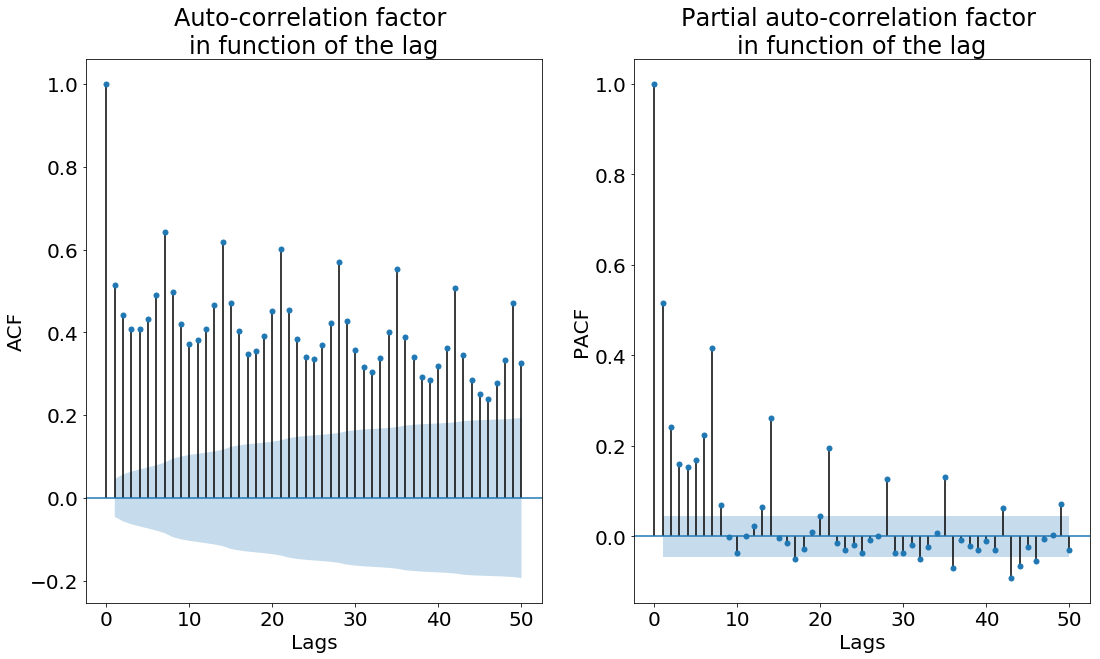

In [11]:
PlotAutoCorrelation(store.sales, [50, 50])

We see the following observations in the ACF and PACF:
- Significant spikes at lags $7s$ in the ACF and the PACF. Since the sales have been taken daily, we deduce that there are weekly seasons because of the spikes at every 7 days.
- The ACF decreases slowly and will reach $0$ at a certain lag.
- Most of the spikes are outside the confidence interval.
- There are 7 significant spikes representing lags $1,2,3,4,5,6,7$ in the PACF and then a cutoff.

Except for seasons, we cannot determine what are the parameters easily. After taking the first order differencing, we should have a better idea because we expect that the trend be stationary.


### First Order of Differencing Time Series
The objective is to see if we can achieve the stationarity of the time series after a first seasonal and non-seasonal order differencing.

In [12]:
sales_diff_non_seasonal = store.sales - store.sales.shift(1)
sales_diff_non_seasonal.dropna(inplace=True)

sales_diff_seasonal = store.sales - store.sales.shift(7)
sales_diff_seasonal.dropna(inplace=True)

Let's plot the non seasonal and seasonal differenced time series with their mean and standard deviation.

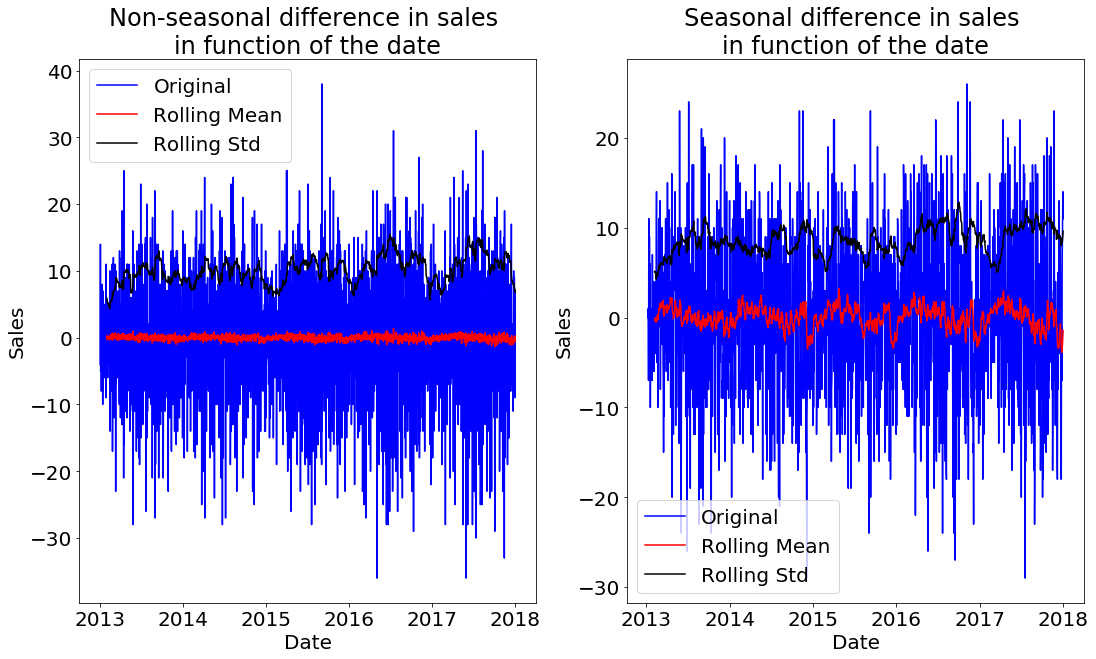

In [13]:
rolmean = sales_diff_non_seasonal.rolling(30).mean()
rolstd = sales_diff_non_seasonal.rolling(30).std()

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(sales_diff_non_seasonal, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Non-seasonal difference in sales \nin function of the date')


rolmean = sales_diff_seasonal.rolling(30).mean()
rolstd = sales_diff_seasonal.rolling(30).std()

plt.subplot(1, 2, 2)
plt.plot(sales_diff_seasonal, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal difference in sales \nin function of the date')
plt.show()

We observe that the mean is quite independent of the time making the first differencing time series stationary. Indeed, in order to get the stationarity of the time series $\{X_t, t \in T\}$, we have to have $E[X_t] = 0$ for all $t \in T$. Lets verify our interpretation with the Dickey-Fuller test.

In [14]:
p_value_limit = 0.01
TestStationarity(sales_diff_non_seasonal, p_value_limit)
TestStationarity(sales_diff_seasonal, p_value_limit)

Results of the Augmented Dickey-Fuller Test:
-----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     446.1
Date:                Sat, 19 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:11:28   Log-Likelihood:                -6031.9
No. Observations:                1805   AIC:                         1.211e+04
Df Residuals:                    1783   BIC:                         1.223e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

We see that after differencing once our time series, we obtain its stationarity. Therefore, we found the following parameters:
- $s = 7$
- $d = 1$ 
- $D = 1$


## Model and Parameters Identification
We found the differencing order for the seasonal and non seasonal time series with its seasonality which is weekly. We have to find what is the value of the parameters $p,q$ for the non seasonal part and $P, Q$ for the seasonal part. 


### Non Seasonal ACF & PACF
Let's see what the non-seasonal ACF and PACF look like for the first differencing order.

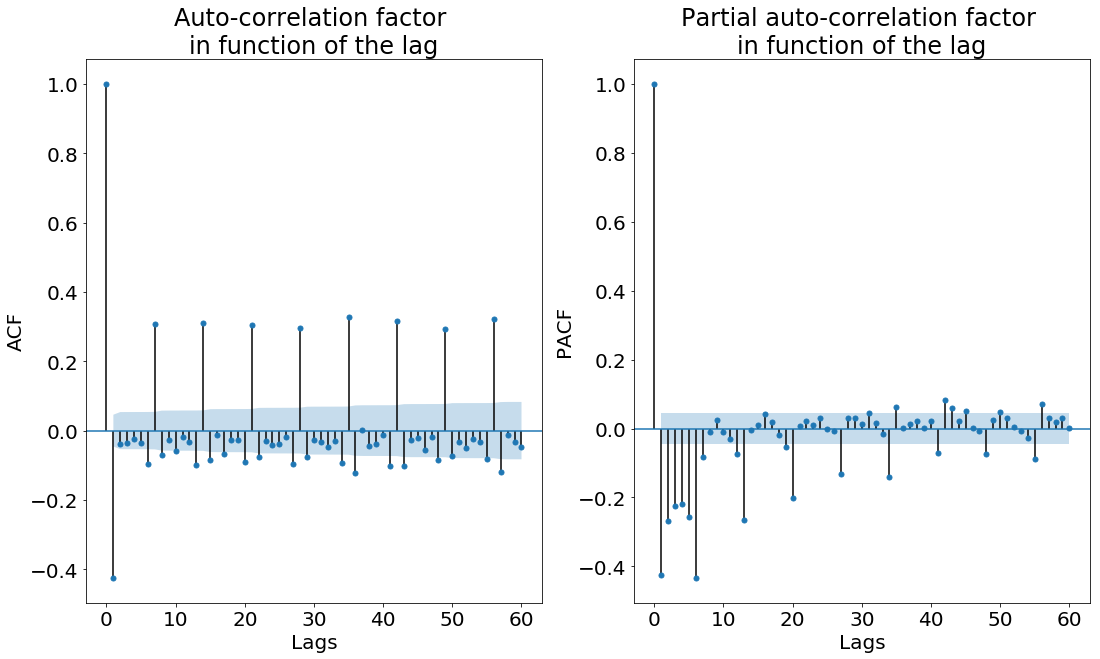

In [15]:
PlotAutoCorrelation(sales_diff_non_seasonal, [60, 60])

After a first order of differencing, we observe the following properties in the ACF and PACF plots:
- In the ACF, the spike at the lag $1$ is considerably negative compared to the others. This suggests a $MA(1)$ process.
- In the ACF, the spikes at lags $7s$ are all significantly positive compared to the others and they are quite constant. This suggests weekly seasons meaning that $s = 7$ and stationarity of the process.
- In the PACF, the lags $1,2,3,4,5,6$ are all significantly negative before the cutoff at lag $7$. This suggests an $AR(6)$ process.

The $ARIMA(6, 1, 1)$ process for the non seasonal part seems to match our observations.


### Seasonal ACF & PACF
Let's see what the first differencing time series seasonal ACF and PACF look like.

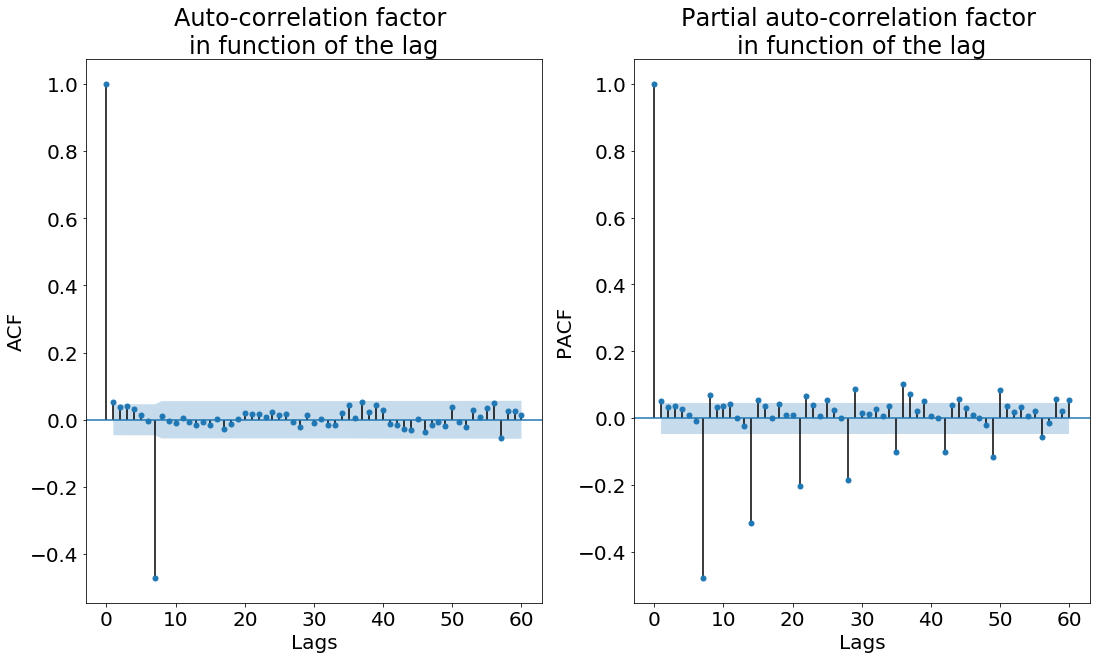

In [16]:
PlotAutoCorrelation(sales_diff_seasonal, [60, 60])

The seasonal ACF suggests that this is a $SMA(1)$ model because the ACF shows a negative significant spike at the first seasonal lag $s = 7$.


### Process Suggested Evaluation
With the observations we got by using the seasonal and non seasonal ACF and PACF, we conclude on the $SARIMA(6, 1, 1)\times(0, 1, 1)_7$ process. In order to evaluate if our process is good or not, we use the AIC (Akaike information criterion). The AIC is a measure of how well a model fits a dataset, while adjusting for the ability of that model to fit any dataset whether or not it is complex.

Lower value of the AIC suggests that the model is getting better. A better model is a simple model using less parameters and obtaining a higher accuracy. The AIC of a model $m$ is represented by
$$AIC_m = 2k_m - 2\ln(\mathcal{L}_m)$$
where $k_m$ is the number of parameters to estimate in the model $m$ and $\mathcal{L}_m$ is the maximum likelihood function of the model $m$.

## Cross-Validation of Process Identified


In [17]:
periodicity = 7
non_seasonal_parameter = (6, 1, 0)
seasonal_parameter = (0, 1, 1, periodicity)

sarima_model = sm.tsa.statespace.SARIMAX(store.sales, 
                                         trend='n', 
                                         order=non_seasonal_parameter,
                                         seasonal_order=seasonal_parameter).fit()
print(sarima_model.summary())

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -6002.305
Date:                           Sat, 19 Jan 2019   AIC                          12020.609
Time:                                   12:11:33   BIC                          12064.653
Sample:                               01-01-2013   HQIC                         12036.860
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8093      0.022    -36.104      0.000      -0.853      -0.765
ar.L2         -0.6699      0.029    -22.970

No need to plot the residual distribution to see if it is a good model because the AIC (Akaike information criterion) is enough to tell that we are missing something else important due to the large AIC.

## SARIMA-X
Since our previous model gave a bad AIC, the objective is to help the model by adding variables that add more explanations on the sales behavior that have not be seen. As the 'X' stands for in 'SARIMA-X', the __exogenous variable__ will explain some behaviors on the sales on the model, but will not be explained by the model. As we listed them at the beginning of the data exploration section, we start with the holidays assuming that the stores are in the US.

### Holidays
We downloaded the file `usholidays.csv` on [Kaggle](https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020) in order to get the necessary holidays in the US that include years 2013 to 2018 inclusively.

In [18]:
holidays = pandas.read_csv('Dataset/usholidays.csv',
                           usecols=["Date", "Holiday"])
holidays.columns = ['date', 'holiday']

exogenous = train.loc[(train.store == store_id) & (train.item == item_id), ['date', 'sales']]

exogenous = exogenous.merge(holidays, how='left', on='date')
exogenous.holiday = pandas.notnull(exogenous.holiday).astype(int)

exogenous = exogenous[['date', 'holiday']]
exogenous.head()

,date,holiday
0,2013-01-01,1
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0


### Weekdays
The objective is to add the exogenous variable 'weekday' in order to identify if the date is Monday ($0$), Tuesday ($1$) until Sunday ($6$). Since the seasons are weekly, this should help the model to get a better accuracy.

In [19]:
exogenous.date = pandas.to_datetime(exogenous['date'])
exogenous['weekday'] = exogenous.date.dt.weekday
exogenous = exogenous.set_index('date')
exogenous.head()

,holiday,weekday
date,,
2013-01-01,1,1
2013-01-02,0,2
2013-01-03,0,3
2013-01-04,0,4
2013-01-05,0,5


In [20]:
mod = sm.tsa.statespace.SARIMAX(endog = store.sales,
                                exog = exogenous,
                                trend='n',
                                order=non_seasonal_parameter,
                                seasonal_order=seasonal_parameter)

model = mod.fit(disp=False)
print(model.summary())

phi = np.round(np.array(model.polynomial_ar), 4)
theta = np.round(np.array(model.polynomial_seasonal_ma), 4)

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -6002.299
Date:                           Sat, 19 Jan 2019   AIC                          12024.598
Time:                                   12:11:41   BIC                          12079.653
Sample:                               01-01-2013   HQIC                         12044.911
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       -0.0941      1.023     -0.092      0.927      -2.099       1.911
weekday        0.0002   2.26e+04    7.9e-09

## Model Equation
The equation of our model is
$$\left(1 - \sum_{i = 1}^6 \alpha_i L^i\right) \Delta_7 X_t = \left(1 + \Theta_1 L^{7}\right) \epsilon_t$$ if and only if
$$(X_t - X_{t-7}) - \sum_{i = 1}^6 \alpha_i (X_{t-i} - X_{t - i - 7}) = \epsilon_t + \Theta_1 \epsilon_{t-7}.$$

Based on the coefficients given by the summary function, we have

In [21]:
from IPython.display import display, Math, Latex
#display(Math(r'(X_t - X_{t-7}) - ' + str(-phi[1]) + '(X_{t-1} - X_{t-8}) -' + str(-phi[2]) + '(X_{t-2} - X_{t-9}) - ' + str(-phi[3]) + '(X_{t-3} - X_{t-10}) - ' + str(-phi[4]) + '(X_{t-4} - X_{t-11}) - ' + str(-phi[5]) + '(X_{t-5} - X_{t-12}) - ' + str(-phi[6]) + '(X_{t-6} - X_{t-13}) - ' + str(-phi[7]) + '(X_{t-7} - X_{t-14}) = \epsilon_t - ' + str(-theta[7]) + ' \epsilon_{t-7}'))

## Residuals Analysis


NormaltestResult(statistic=7.334249882403047, pvalue=0.025549821690516707)


/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


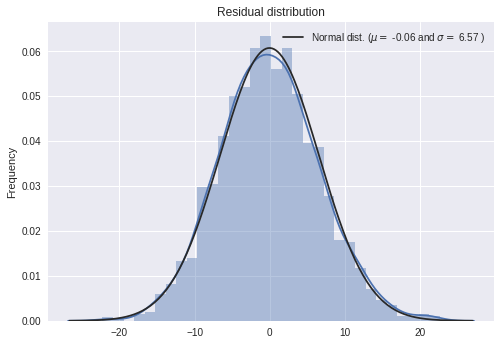

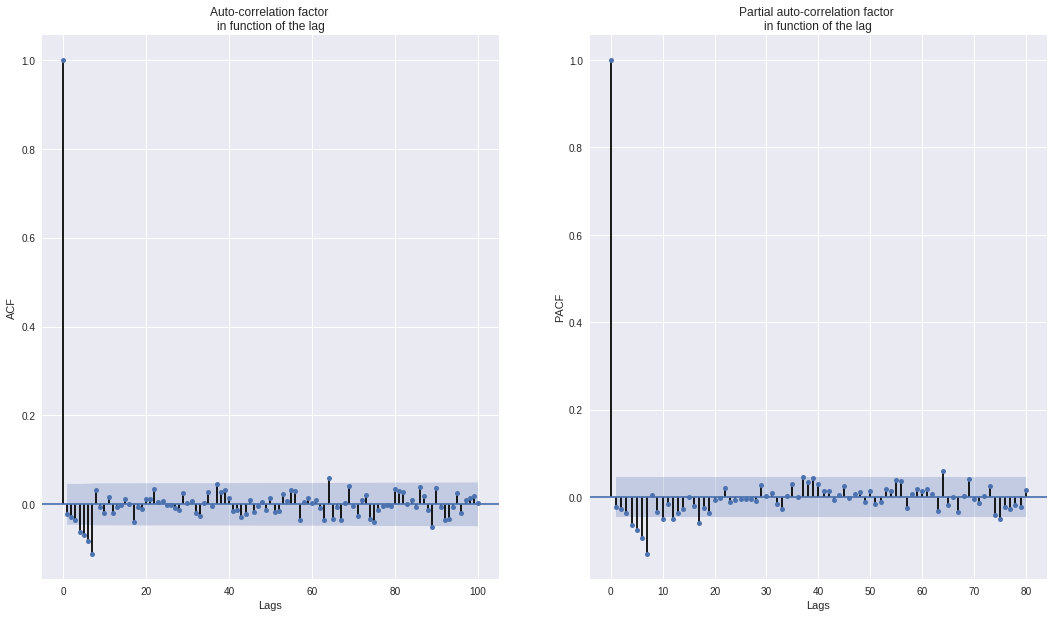

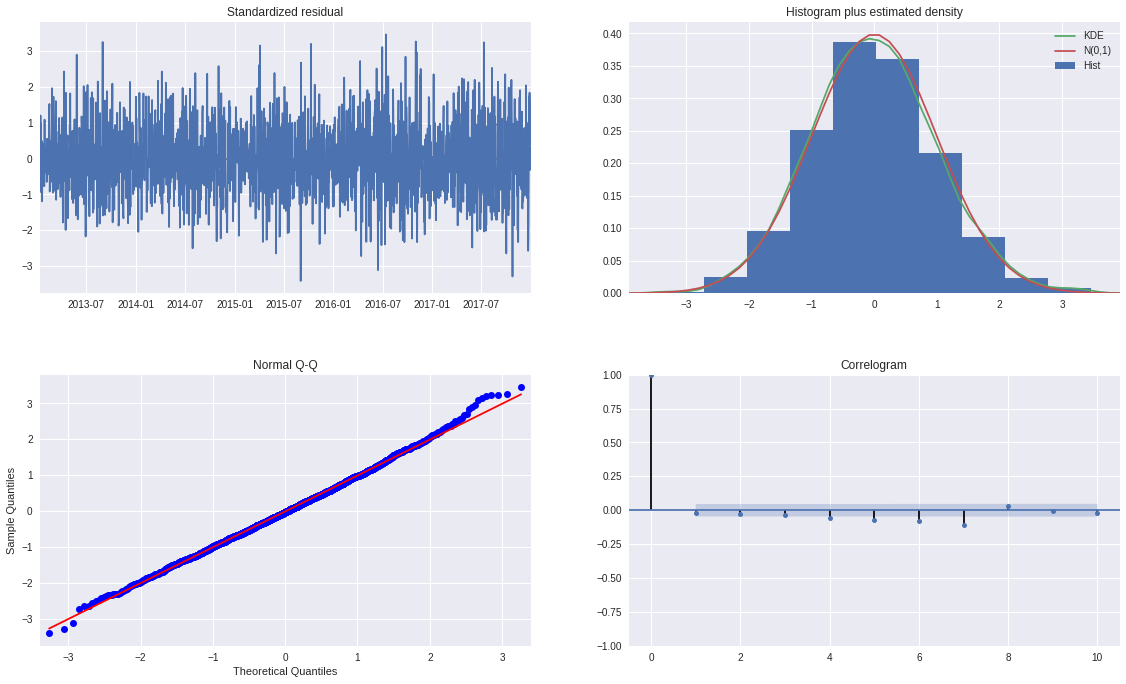

In [22]:
print(normaltest(model.resid))
import seaborn as sns
sns.distplot(model.resid ,fit = stats.norm)
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(model.resid)

# Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

PlotAutoCorrelation(model.resid, [100, 80])

model.plot_diagnostics()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.7, wspace=None, hspace=0.3)

### Interpretation
We know that the standardized residuals distribution has to follow a normal distribution with mean $0$ and variance $1$ which is a gaussian white noise.

## Cross-Validation
The objective is to split the train dataset in order to compare our predicted 3 months with the 3 last months in our test dataset which represents the 3 last months of the train dataset.

The first step is to split our train dataset in order to build our test dataset:
- Train set is from 2013-01-01 to 2017-09-30 inclusively.
- Test set is from 2017-10-01 to 2017-12-31 inclusively.

Let $MAE(X_t, \hat{X}_t)$ be the mean absolute error defined by
$$MAE(X_{t + j}, \hat{X}_{t+j}) = \frac{1}{n} \sum_{i = 1}^n |\frac{(X_{t + i} - \hat{X}_{t + i})}{X_{t + i}}|.$$

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


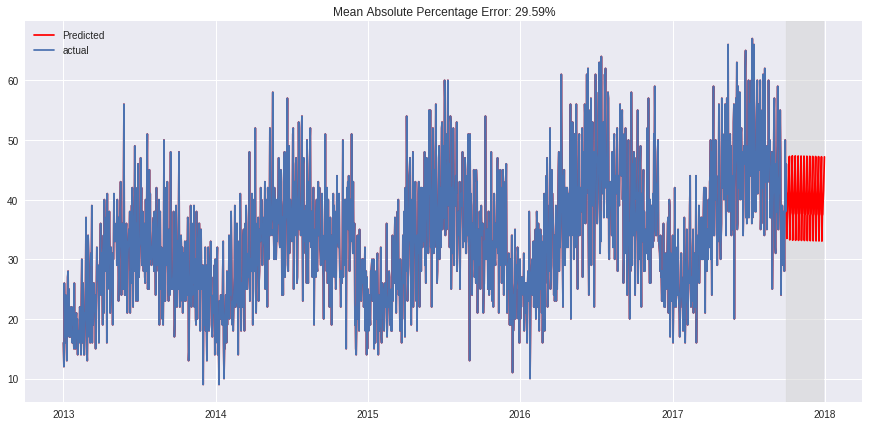

In [23]:
test_set = store['2017-10-01':]
train_set = store[:'2017-09-30']

mod = sm.tsa.statespace.SARIMAX(train_set,
                                trend='c',
                                order=non_seasonal_parameter,
                                seasonal_order=seasonal_parameter,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model = mod.fit(disp=False)
forecast = pandas.DataFrame(model.predict(start = train_set.shape[0], end = train_set.shape[0] + test_set.shape[0] - 1))
forecast.columns = ['sales']
forecast.index.names = ['date']
train_forecast = train_set.append(forecast)

error = mean_absolute_percentage_error(test_set, forecast)['sales']

plt.figure(figsize=(15, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(train_forecast, color='r', label="Predicted")
plt.axvspan(train_set.index[-1], train_forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train_set, label="actual")
plt.legend()
plt.grid(True);